# Klasör Bağlantıları

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME ='ssd_mobilenet_v2' 
PRETRAINED_MODEL_NAME ='ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'
PRETRAINED_MODEL_URL ='http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME ='generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}


In [ ]:
for path in paths.values():
    if not os.path.exists(path):
        !mkdir {path}

# Tesorflow model API yükleme

In [ ]:
import wget

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
url="https://github.com/protocolbuffers/protobuf/releases/download/v3.19.4/protoc-3.19.4-win64.zip"
wget.download(url)
!move protoc-3.19.4-win64.zip {paths['PROTOC_PATH']}
!cd {paths['PROTOC_PATH']} && tar -xf protoc-3.19.4-win64.zip 

In [ ]:
os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))

In [ ]:
!cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=.

In [ ]:
!cd Tensorflow/models/research && copy object_detection\\packages\\tf2\\setup.py setup.py

In [ ]:
!cd Tensorflow/models/research && python setup.py build

In [ ]:
!cd Tensorflow/models/research && python setup.py install

In [ ]:
!cd Tensorflow/models/research/slim && pip install -e .

In [ ]:
##Model çalışıyor mu?
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
!python {VERIFICATION_SCRIPT}

In [ ]:
import object_detection

In [ ]:
wget.download(PRETRAINED_MODEL_URL)
!move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}

In [ ]:
!cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# Label Map text dosyası oluşturma

In [ ]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# Train ve Test Doğruluk kayıt dosyası oluşturma

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/UmutUcay/LPDR/blob/main/generate_tfrecord.py {paths['SCRIPTS_PATH']}

In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

# Model dosyalarını kopyalama

In [ ]:
!copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# Egitim için Dosyaları hazırlama

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 3
pipeline_config.train_config.optimizer.momentum_optimizer.learning_rate.cosine_decay_learning_rate.learning_rate_base = 0.05
pipeline_config.train_config.optimizer.momentum_optimizer.learning_rate.cosine_decay_learning_rate.warmup_learning_rate = 0.025
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# Eğitim komut satırı oluşturma

In [6]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
print(command)

In [ ]:
!pip list

# Model Detayları

In [7]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [8]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\ssd_mobilenet_v2 --pipeline_config_path=Tensorflow\workspace\models\ssd_mobilenet_v2\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\ssd_mobilenet_v2


# Modeli Yükleme

In [5]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RunTimeError as e:
        print(e)

In [7]:
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)


ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-51')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Görsel üzerinde test

In [8]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [17]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', '18628120.jpg')

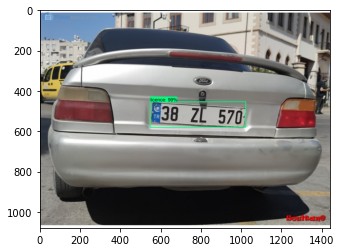

In [18]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.7,
            agnostic_mode=False)


plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
######################################################

In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import easyocr
import uuid
from PIL import Image

In [13]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [33]:
def ocr_plate(image):
    detection_threshold = 0.7
    region_threshold = 0.1
    width = image.shape[1]
    height = image.shape[0]

    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]

    for idx, box in enumerate(boxes):
            roi = box*[height, width, height, width]
            region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    
    img = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)
    
    #threshold_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,11,3)
    
    ret,threshold_img = cv2.threshold(img,40,70,cv2.THRESH_BINARY)
    
    
    #plt.imshow(threshold_img)
    
    kernel = np.ones((2,2),np.uint8)
    threshold_img = cv2.morphologyEx(threshold_img,cv2.MORPH_OPEN,kernel,iterations=1)
    
    #cv2.imwrite('Detection_Images/a.png', threshold_img)
    
    reader = easyocr.Reader(['tr'])
    ocr_result = reader.readtext(threshold_img)
    text = filter_text(threshold_img, ocr_result, region_threshold)
    
    #image_path = 'C:\TFOD\'
    
    #print(' '.join(text))
    plt.imshow(img)
    #return text,region
 

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


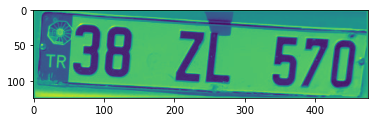

In [34]:
ocr_plate(image_np_with_detections)


In [ ]:
my_images = os.listdir(os.path.join(paths['IMAGE_PATH'], 'OCR_test'))

In [ ]:
for image_name in my_images:
    IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'OCR_test', image_name)
    img = cv2.imread(IMAGE_PATH)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.7,
            agnostic_mode=False)
    try:
        text, image_thick = ocr_plate(image_np_with_detections)
    except:   
        cv2.imwrite("Tensorflow/ocr_test_images/"+ str(text) + ".jpg" , image_thick)

# Gerçek zamanlı tespit

In [ ]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import csv
import uuid
import time
from difflib import SequenceMatcher
import logging

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [ ]:
region_threshold = 0.6

In [ ]:
detection_threshold = 0.7

In [ ]:
def save_results(text, region, csv_filename, folder_path):
    img_name = '{}.jpg'.format(uuid.uuid1())
    
    cv2.imwrite(os.path.join(folder_path, img_name), region)
    
    with open(csv_filename, mode='a', newline='') as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([img_name, text])

In [ ]:
def solve_eq(string1):
    string1 = ''.join(string1)
    string1 = string1.upper()
    return string1.replace(' ', '')

In [ ]:
def similar_frame(old_frame, frame):
    res = cv2.absdiff(old_frame, frame)
    res = res.astype(np.uint8)
    percentage = (numpy.count_nonzero(res) * 100)/ res.size
    return percentage

In [ ]:
cap = cv2.VideoCapture('deneme2.3gp')
cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter.fourcc('m','j','p','g'))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
prev_frame_time = 0
new_frame_time = 0

#log dosyası
logging.basicConfig(
    filename="logfile.txt",
    format="%(asctime)s - %(levelname)s - %(message)s ",
    filemode="w",level=logging.DEBUG)
logger = logging.getLogger()

#Kayıtlı plakalara erişim
file = open("saved_plate.csv")
csvreader = csv.reader(file)
#header = next(csvreader)
rows = []
for row in csvreader:
    rows.append(row)
file.close()

count_fps = 0
while cap.isOpened(): 
    ret, frame = cap.read()
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    new_frame_time = time.time()
    fps = 1/(new_frame_time-prev_frame_time)
    prev_frame_time = new_frame_time
    fps = int(fps)
    fps = str(fps)
    cv2.putText(frame, fps, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA)
    
    image_np = np.array(frame)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.7,
                agnostic_mode=False)
    
    count_fps = count_fps + int(fps)
    #print(count_fps)
    if(count_fps >= 60):
        try:
            text, region = ocr_plate(image_np_with_detections)
            text1 = solve_eq(text)
            print(text1)
            for plate in rows:
                print("plate: ",plate)
                if text1 == plate[0]:
                    print("Door is Opening")
                    #logger.info("Door is Open: %s",text1)     
            logger.info("plate: %s",text1)
            count_fps = 0
            #save_results(text, region, 'realtimeresults.csv', 'Detection_Images')
        except:
            pass

    cv2.imshow("object detection",  cv2.resize(image_np_with_detections, (640, 480)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break
        


In [ ]:
text = '19 Au244'
text1 = ''.join(text)
text1 = text1.replace(' ','')
text1 = text1.upper()
print(text1)

In [ ]:
#Kayıtlı plakalara erişim
file = open("saved_plate.csv")
csvreader = csv.reader(file)
#header = next(csvreader)
rows = []
for row in csvreader:
    rows.append(row)
file.close()
text1 = '19AU244'
for plate in rows:
    print(plate[0])


In [ ]:
text1='19AU244'
text2='19AU244'

if text1 == text2:
    print("dasd")